 Graph Neural Network (GNN) based model that models user-song preferences based on data collected from Last.fm

# load data

In [1]:
# import required modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy
from torch_geometric.utils import degree
import time
import torch
from torch import nn, optim, Tensor
from tqdm.notebook import tqdm

In [2]:
data = pd.read_excel('/Users/yaoyi/Desktop/4222 project/lastfm_users_songs.xlsx')

In [3]:
from ast import literal_eval
data_liked = data.copy(deep = True)
data_liked = data_liked[['User', 'Liked Songs']]
data_liked['Liked Songs'] = data_liked['Liked Songs'].apply(literal_eval)

a naive approach to elimimate the more obvious non-english songs 

In [4]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
# alternative spacy, but might not be very accurate also

In [5]:
data_liked = data_liked.explode('Liked Songs')
data_liked['languages'] = data_liked['Liked Songs'].apply(lambda x: isEnglish(str(x)))
data_liked = data_liked.loc[data_liked['languages'] == True]
data_liked = data_liked.drop(columns = 'languages')

In [6]:
data_liked['Liked Songs'].value_counts().index.sort_values()

Index(['!!!', '!!Noble Stabbings!!', '!liaF cipE', '!ntro', '"40"', '"45"',
       '"5150"', '"Boom"',
       '"Btw, that untitled song on your mixtape was for you. i wrote it when i missed you."',
       '"But there's only one you need to hear from tonight..."',
       ...
       'zzyzx_rd.', '{ encounter: naiad_guardian.xiv }', '{ }', '{idle}',
       '|Believer|', '|||', '|||171||| So Hiiigh |||171|||', '~',
       '~Electric De Chocobo~', '~lonely birds~'],
      dtype='object', name='Liked Songs', length=127240)

In [7]:
unique_songs = data_liked['Liked Songs'].unique()
len(unique_songs)

127241

In [8]:
# interaction_matrix = pd.crosstab(data_liked['User'], data_liked['Liked Songs'])
# interaction_matrix

Liked Songs,!!!,!!Noble Stabbings!!,!liaF cipE,!ntro,"""40""","""45""","""5150""","""Boom""","""Btw, that untitled song on your mixtape was for you. i wrote it when i missed you.""","""But there's only one you need to hear from tonight...""",...,zzyzx_rd.,{ encounter: naiad_guardian.xiv },{ },{idle},|Believer|,|||,|||171||| So Hiiigh |||171|||,~,~Electric De Chocobo~,~lonely birds~
User,,,,,,,,,,,,,,,,,,,,,
-GS-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0-172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40belowsummer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zyluzza,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zymad,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zyomra,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# interaction_matrix = pd.crosstab(data_liked['User'], data_liked['Liked Songs'])
# interaction_matrix
# interaction_matrix_sparse = interaction_matrix.to_numpy()
# interaction_matrix_sparse
# from scipy import sparse
# interaction_matrix_coo = sparse.coo_matrix(interaction_matrix_sparse)
# interaction_matrix_coo
# # edge_index is just [row, col] from COO format
# edge_index =  [interaction_matrix_coo.row, interaction_matrix_coo.col]

# print(edge_index[0])
# print(edge_index[1])

# print(interaction_matrix_coo.todense())

[   0    0    0 ... 7817 7817 7817]
[  1889   2053   6229 ... 118085 120528 123684]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [8]:
num_users = len(data_liked['User'].unique())
num_songs = len(data_liked['Liked Songs'].unique())
print(num_users, num_songs)

10017 127241


## train test split

In [9]:
# label both users and loved songs
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

lbl_user = preprocessing.LabelEncoder()
lbl_songs = preprocessing.LabelEncoder()

train, test = train_test_split(data_liked.values, test_size=0.2, random_state = 0)
train = pd.DataFrame(train, columns = data_liked.columns)
test = pd.DataFrame(test, columns = data_liked.columns)
print("Train Size  : ", len(train))
print("Test Size : ", len (test))

train['User idx'] = lbl_user.fit_transform(train['User'].values)
train['Liked Songs idx'] = lbl_songs.fit_transform(train['Liked Songs'].values)
train_user_ids = train['User'].unique()
train_song_ids = train['Liked Songs'].unique()
print(len(train_user_ids), len(train_song_ids))

# Ensure that the test set only contains users and liked songs that also appear in the training set
test = test[(test['User'].isin(train_user_ids)) & (test['Liked Songs'].isin(train_song_ids))]
print(len(test))

# Transform user and liked songs in the test set using the label encoders fitted on the training set
test['User idx'] = lbl_user.transform(test['User'].values)
test['Liked Songs idx'] = lbl_songs.transform(test['Liked Songs'].values)
# Calculate the number of unique users and songs in the training set
n_users = train['User idx'].nunique()
n_songs = train['Liked Songs idx'].nunique()
print("Number of Unique Users: ", n_users)
print("Number of unique songs : ", n_songs)


Train Size  :  237800
Test Size :  59450
9515 108609
39576
Number of Unique Users:  9515
Number of unique songs :  108609


In [10]:
train

,User,Liked Songs,User idx,Liked Songs idx
0,lastlings,P()L4R,6280,65641
1,mihanoid,Superplus,6872,83540
2,gagaanddiamonds,Your Love (9PM),5044,102994
3,Chrilu,The Blind Man,480,86633
4,kritiknokta,HEY DOUGLAS Live in Europe Set 2013,6184,36316
...,...,...,...,...
237795,Schnaeck,Slam the box,2426,78561
237796,junsus,Cool With You,5984,18961
237797,Teenagedirtbag8,Morning Theft,2685,58335
237798,Caleb_musicgood,Rakata,426,70943


### Matrix transformation


Function `relevance_score_matrix_dense` to form the interaction matrix between users and songs for train and test set in later parts 

In [11]:
import torch
import scipy.sparse as sp

# Define a function to construct a relevance interaction matrix
# combining the output from function convert_to_sparse_tensor in lightGCN.ipynb and following manipulation
def relevance_score_matrix_dense(n_users, n_songs, data, user_col, song_col):
    dok_mtrx = sp.dok_matrix((n_users, n_songs), dtype = np.float32)
    dok_mtrx[data[user_col], data[song_col]] = 1.0

    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)  # Convert DOK matrix to COO format and ensure data type
    values = dok_mtrx_coo.data  # Extract non-zero values
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    dok_mtrx_dense_tensor = dok_mtrx_sparse_tensor.to_dense()

    # Set non-interacted items in the relevance score matrix to negative infinity
    dok_mtrx_dense_tensor = dok_mtrx_dense_tensor*(-np.inf)
    dok_mtrx_dense_tensor = torch.nan_to_num(dok_mtrx_dense_tensor, nan=0.0)
    return dok_mtrx_dense_tensor

In [12]:
R_tensor_dense = relevance_score_matrix_dense(n_users, n_songs, train, 'User idx', 'Liked Songs idx')
R_tensor_dense

/var/folders/2b/x4_dglq94mggvcmfjft1qw380000gn/T/ipykernel_68551/996459183.py:18: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))


tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -3.4028e+38],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -3.4028e+38],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -3.4028e+38]])


- `latent_dim` is the length of the user/item embedding.

- `n_layers` is the number of times we want to propagate our initial user/item embedding through the graph

In [13]:
# Set model hyperparameters: latent dimension and number of layers
latent_dim = 64  # Dimensionality of the latent feature space
n_layers = 3  # Number of layers in the neural network


## Metrics

# Evaluation Metrics

We evalaluate our model using the following metrics

\begin{equation}
\text{Recall} = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
\text{Precision} = \frac{TP}{TP + FN}
\end{equation}

Recall@k and Precision@k is just applying only the topK recommended items and then for the overall
Recall@k and Precision@k, it's just averaged by the number of users

**Dicounted Cumulative Gain (DCG)** at rank position p is defined as:

\begin{equation}
\text{DCG}_\text{p} = \sum_{i = 1}^p \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

p: a particular rank position

$rel_i \in \{0, 1\}$ : graded relevance of the result at position $i$

**Idealised Dicounted Cumulative Gain (IDCG)**, namely the maximum possible DCG, at rank position $p$ is defined as:

\begin{equation}
\text{IDCG}_\text{p} = \sum_{i = 1}^{|REL_p|} \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

$|REL_p|$ : list of items ordered by their relevance up to position p

**Normalized Dicounted Cumulative Gain (NDCG)** at rank position $p$ is defined as:

\begin{equation}
\text{nDCG}_\text{p} = \frac{\text{DCG}_p}{\text{nDCG}_p}
\end{equation}

Specifically, we use the metrics recall@K, precision@K, and NDCG@K. @K indicates that these metrics are computed on the top K recommendations.

In [14]:
import torch.nn as nn

#  Function to compute evaluation metrics for a recommendation system model
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_songs, train_data, test_data, K):

    # Initialize user and item embeddings using pre-trained weights
    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight = item_Embed_wts)

    # Get unique user IDs in the test set
    test_user_ids = torch.LongTensor(test_data['User idx'].unique())

    # Compute relevance score matrix based on user and item embeddings
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))
    
    R_tensor_dense = relevance_score_matrix_dense(n_users, n_songs, train_data, 'User idx', 'Liked Songs idx')

    # Add the relevance score matrix and the non-interacted items matrix
    relevance_score = relevance_score + R_tensor_dense

    # Retrieve the top-K relevance scores and their corresponding indices
    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    # Convert top-K relevance indices to a DataFrame
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    # Group the test set by user ID and retrieve the list of interacted items
    test_interacted_items = test_data.groupby('User idx')['Liked Songs idx'].apply(list).reset_index()

    # Merge the interacted items list with the top-K relevance indices DataFrame
    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'User idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df['Liked Songs idx'], metrics_df.top_rlvnt_itm)]

    # Compute recall, precision, and hit list metrics
    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['Liked Songs idx']), axis = 1)
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    # Check if each recommended item is in the interacted item list
    def get_hit_list(item_id_idx, top_rlvnt_itm):
        return [1 if x in set(item_id_idx) else 0 for x in top_rlvnt_itm ]
    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['Liked Songs idx'], x['top_rlvnt_itm']), axis = 1)

    # Calculate the ideal DCG (IDCG) based on the number of interacted items and the hit list
    def get_dcg_idcg(item_id_idx, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(item_id_idx),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg
    # normalized discounted cumulative gain
    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['Liked Songs idx'], x['hit_list']), axis = 1)

    # Calculate the cumulative sum of hits in the hit list
    def get_cumsum(hit_list):
        return np.cumsum(hit_list)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    # Calculate the mean average precision (MAP) for a user
    def get_map(item_id_idx, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)
    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['Liked Songs idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean()

## Model

if j has a lot of neighbours, the message the node i gets should be weaker

# Implementing LightGCN

## Light Graph Convolution
Between each layer, LightGCN uses the following propagation rule for user and item embeddings.

**symmetric normalization: considers nerighbour count & target neighbour count**

\begin{equation}
e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}} e_i^{(k)} \quad e_i^{(k+1)} = \sum_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}} e_u^{(k)}
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding



## Layer Combination and Model Prediction
The only trainable parameters of LightGCN are the 0-th layer embeddings $e_u^{(0)}$ and $e_i^{(0)}$ for each user and item. We combine the embeddings obtained at each layer of propagation to form the final embeddings for all user and item, $e_u$ and $e_i$ via the follwing equation.
**sometimes, for alpha, we can just use 1/number of layers**
an element wised average for final embedding

\begin{equation}
e_u = \sum_{k = 0}^K \alpha_k e_u^{(k)} \quad e_i = \sum_{k = 0}^K \alpha_k e_i^{(k)}
\end{equation}

$\alpha_k$ : hyperparameter which weights the contribution of the k-th layer embedding to the final embedding

The model prediction is obtained by taking the inner product of the final user and item embeddings.

\begin{equation}
\hat{y}_{ui} = e_u^Te_i
\end{equation}

## Matrix Form
In our implementation, we utilize the matrix form of LightGCN. We perform multi-scale diffusion to obtain the final embedding, which sums embeddings diffused across multi-hop scales. 

\begin{equation}
E^{(K)} = \alpha_0 E^{(0)} + \alpha_1 \tilde{A}^1 E^{(0)} + \alpha_2 \tilde{A}^2 E^{(0)} + \cdot \cdot \cdot + \alpha_K \tilde{A}^K \tilde{A} E^{(0)}
\end{equation}

$E^{(0)} \in \mathcal{R}^{(M + N)} \times T$ : stacked initial item and user embeddings where $M$, $N$, and $T$ denote the number of users, number of items, and the dimension of each embedding respectively

$\tilde{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$ : symmetrically normalized adjacency matrix

D: diagonal matrix
A: adjacency matrix

In [15]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_songs, n_layers = 3, latent_dim = 64):
        super(LightGCN, self).__init__()
        self.data = data
        self.n_users = n_users
        self.n_songs = n_songs
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        #normalized adj matrix
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        # embedding dimension: num_user/num_songs * embedding_dim
        # self.users_emb = nn.Embedding(self.n_users, self.latent_dim)
        # self.songs_emb = nn.Embedding(self.n_songs, self.latent_dim)
        ## fills the input tensor with values from normal distribution, and according to paper, this gives better performance
        # nn.init.normal_(self.users_emb.weight, std = 0.1)
        # nn.init.normal_(self.songs_emb.weight, std = 0.1)
        self.E0 = nn.Embedding(self.n_users + self.n_songs, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    # the normalized adajency matrix in a sparse tensor
    def get_A_tilda(self):
        R = sp.dok_matrix((self.n_users, self.n_songs), dtype = np.float32)
        R[self.data['User idx'], self.data['Liked Songs idx']] = 1.0

        # Create adjacency matrix for the user-item graph
        adj_mat = sp.dok_matrix(
                (self.n_users + self.n_songs, self.n_users + self.n_songs), dtype=np.float32
            )
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: n_users, n_users :] = R
        adj_mat[n_users :, : n_users] = R.T
        adj_mat = adj_mat.todok()

        # Normalize the adjacency matrix
        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)

        # Convert the dok_matrix to sparse tensor.

        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor

    # propagate user and item embeddings through the network for a specified number of layers
    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            # matrix multiplication of sparse matrix and layer weights
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        # shape n_nodes * (n_layers + 1) * emb_vector_len
        all_layer_embedding = torch.stack(all_layer_embedding, dim = 1)
        # setting a_k uniformly as 1/(K+1) 
        mean_layer_embedding = torch.mean(all_layer_embedding, dim = 1)

        # split into e_u^k and e_i^k 
        final_user_Embed, final_song_Embed = torch.split(mean_layer_embedding, [n_users, n_songs])
        initial_user_Embed, initial_song_Embed = torch.split(self.E0.weight, [n_users, n_songs])

        return final_user_Embed, final_song_Embed, initial_user_Embed, initial_song_Embed

    # define the forward pass of the model, compute the final embeddings for given users and items
    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_song_Embed, initial_user_Embed, initial_song_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_song_Embed[pos_items], final_song_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_song_Embed[pos_items], initial_song_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0

In [16]:
lightGCN = LightGCN(train, n_users, n_songs, 3, 64)
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([118124, 64])


Aggregation: To combine information from neighbor nodes, different techniques like mean-pooling, attention mechanism, and others can be used.

Update: To combine aggregated information with the representation of a node, there are several techniques that can be used, such as using a GRU (Gated Recurrent Unit) or simply summing up the information.

Prediction: The last updated representation of either the user or item, known as the node representation, is utilized as input for the intended prediction task.

**user item bipartite graph**

'''
In bipartite graph, interaction matrix is not the same as adjacency matrix, because adjacency matrix
expecteds row index and col index to refer to the same node

perform the conversion between interaction matrix (r_mat) and adjacency matrix (adj_mat)
    ( 0    R )
A = ( R_T  0 )

so if dimension of R is  n_user x n_item
then dimension of A is (n_user+n_item) x (n_user+n_item)

'''


self-supervised learning 

(signals come from the graph themselves)

we treat all unobserved interactions as the negative instances when reporting performance.

For example, a user will be linked to song they liked, to song they ranked as top song.




Construct the graph

In [17]:
import random

# helper function for training and compute BPR loss
# since this is a self-supervised learning, we are relying on the graph structure itself and 
# we don't have label other than the graph structure so we need to the folloing function
# which random samples a mini-batch of positive and negative samples
def data_loader(data, user_col, song_col, batch_size, n_usr, n_itm):
    # Group interactions by user ID and sample negative items
    interected_items_df = data.groupby(user_col)[song_col].apply(list).reset_index()

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    indices = [x for x in range(n_usr)]

    # Randomly select users for batch training
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()

    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = user_col, right_on = 'users')

    # Select positive and negative items for each user
    pos_items = interected_items_df[song_col].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df[song_col].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

**Loss function** 
https://www.youtube.com/watch?v=h1zxhx815Fk 

cannot use RMSE as this self-supervised learning cannot rely on rating labels to compute loss

Bayesian personalized ranking loss 
-- forces the positive score to be higher and the negative score to be lower

$L_{BPR} = - \sum _{u=1}^M \sum_{i \in N_u} \sum_{j\notin N_u} \ln \sigma(\hat{y_{ui}}- \hat{y_{uj}}) + \lambda ||E^{(0)}||^2$

and $\hat{y_{ui}}$ is predicted score of positive interaction of two nodes

 $\hat{y_{uj}}$ is predicted score of negative interaction of two nodes

 $\lambda$ is the hyperparameter that controls the L2 regularization strength

 $E^{(0)}$ is the embedding at layer 0 for all nodes


In our project, positive samples are: user liked songs

negative samples are: songs user did not like

from paper https://arxiv.org/pdf/2002.02126.pdf, the performance drops drastically when lambda is larger than 1e^-3

for the lambda used in prof's code: (1/2)/float(len(users))

In [18]:
# parameters: user embedding finals, user embedding initial, 
def bpr_loss(users, users_emb_final, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0, lam = 1/2):
    # Compute regularization loss
    reg_loss = lam * (userEmb0.norm().pow(2) +
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))

    # Compute scores for positive and negative items
    pos_scores = torch.mul(users_emb_final, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb_final, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)

    # Compute BPR loss using softplus function
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
    return loss, reg_loss

## Model Training

In [25]:
LR = 1e-2
# define contants
ITERATIONS = 10000
EPOCHS = 10
BATCH_SIZE = 1024
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-3
DECAY = 0.001
# LAMBDA = 1/2
user_col = 'User idx'
song_col = 'Liked Songs idx'

In [26]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = LR)


In [ ]:
from tqdm.notebook import tqdm

In [32]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = []

for epoch in tqdm(range(EPOCHS)):
    # Calculate the number of batches per epoch
    n_batch = int(len(train)/BATCH_SIZE)

    # Initialization
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
    best_ndcg = -1
    train_start_time = time.time()

    # Set the model in training mode
    lightGCN.train()

    # Iterate over each batch in the training dataset
    for batch_idx in range(n_batch):
        # Reset gradients
        optimizer.zero_grad()
        # Load data for the current batch
        users, pos_items, neg_items = data_loader(train, user_col, song_col, BATCH_SIZE, n_users, n_songs)
        # Perform forward pass through the model
        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)
        # Compute BPR loss and regularization loss
        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0, LAMBDA)
        reg_loss = DECAY * reg_loss  # Apply weight decay
        # Combine losses to get the final loss
        final_loss = mf_loss + reg_loss
        # Perform backward pass and update model parameters
        final_loss.backward()
        optimizer.step()
        # Record losses for monitoring
        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    # model evaluation
    lightGCN.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_songs, train, test, K)


    eval_time = time.time() - train_end_time

    # calculate and append the mean values of various loss and evaluation metrics for each epoch to their respective lists.
    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)

  0%|          | 0/10 [00:00<?, ?it/s]

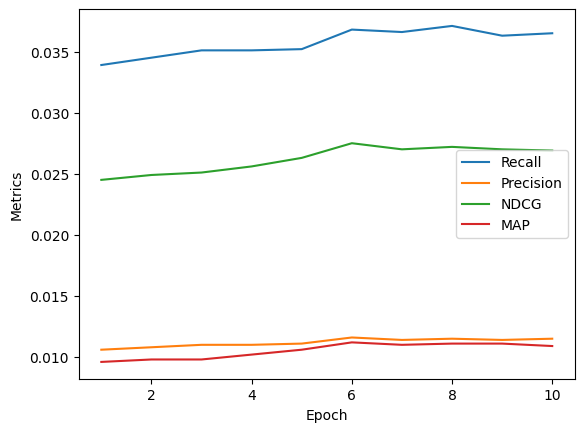

In [33]:
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

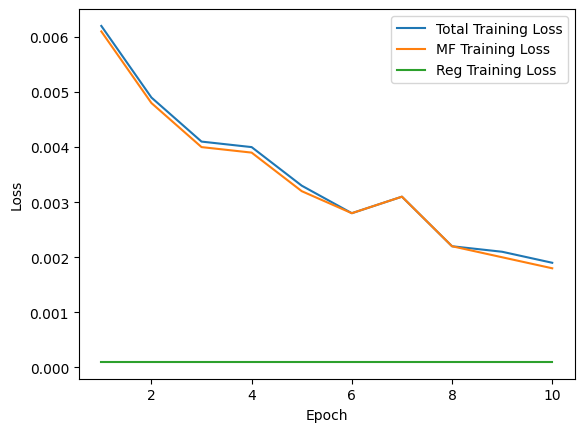

In [34]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [20]:
LR = 1e-3
# define contants
ITERATIONS = 10000
EPOCHS = 30
BATCH_SIZE = 1024
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 10
LAMBDA = 1/2 / float((n_users))
DECAY = 0.001
# LAMBDA = 1/2
user_col = 'User idx'
song_col = 'Liked Songs idx'

In [21]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = LR)


In [22]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = []

for epoch in tqdm(range(EPOCHS)):
    # Calculate the number of batches per epoch
    n_batch = int(len(train)/BATCH_SIZE)

    # Initialization
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
    best_ndcg = -1
    train_start_time = time.time()

    # Set the model in training mode
    lightGCN.train()

    # Iterate over each batch in the training dataset
    for batch_idx in range(n_batch):
        # Reset gradients
        optimizer.zero_grad()
        # Load data for the current batch
        users, pos_items, neg_items = data_loader(train, user_col, song_col, BATCH_SIZE, n_users, n_songs)
        # Perform forward pass through the model
        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)
        # Compute BPR loss and regularization loss
        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0, LAMBDA)
        reg_loss = DECAY * reg_loss  # Apply weight decay
        # Combine losses to get the final loss
        final_loss = mf_loss + reg_loss
        # Perform backward pass and update model parameters
        final_loss.backward()
        optimizer.step()
        # Record losses for monitoring
        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    # model evaluation
    lightGCN.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_songs, train, test, K)


    eval_time = time.time() - train_end_time

    # calculate and append the mean values of various loss and evaluation metrics for each epoch to their respective lists.
    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)

  0%|          | 0/30 [00:00<?, ?it/s]

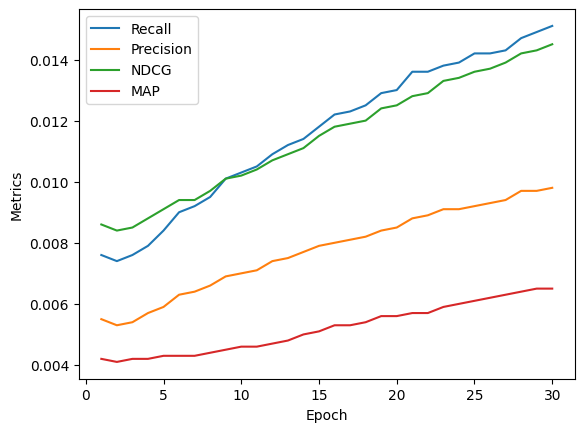

In [23]:
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

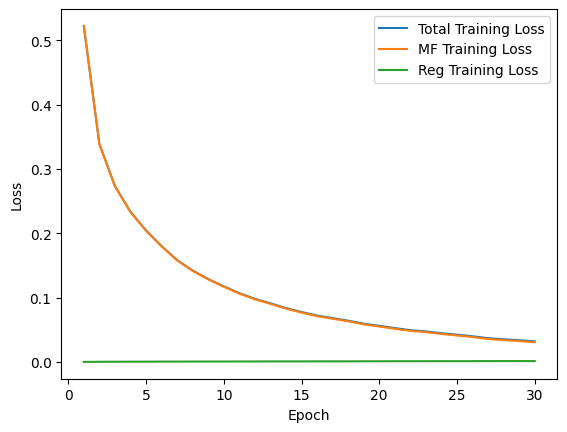

In [24]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [25]:
lightGCN = LightGCN(train, n_users, n_songs, 3, 16)
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([118124, 16])


In [26]:
LR = 1e-2
# define contants
ITERATIONS = 10000
EPOCHS = 10
BATCH_SIZE = 1024
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-3
DECAY = 0.001
# LAMBDA = 1/2
user_col = 'User idx'
song_col = 'Liked Songs idx'

In [27]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = LR)


In [28]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = []

for epoch in tqdm(range(EPOCHS)):
    # Calculate the number of batches per epoch
    n_batch = int(len(train)/BATCH_SIZE)

    # Initialization
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
    best_ndcg = -1
    train_start_time = time.time()

    # Set the model in training mode
    lightGCN.train()

    # Iterate over each batch in the training dataset
    for batch_idx in range(n_batch):
        # Reset gradients
        optimizer.zero_grad()
        # Load data for the current batch
        users, pos_items, neg_items = data_loader(train, user_col, song_col, BATCH_SIZE, n_users, n_songs)
        # Perform forward pass through the model
        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)
        # Compute BPR loss and regularization loss
        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0, LAMBDA)
        reg_loss = DECAY * reg_loss  # Apply weight decay
        # Combine losses to get the final loss
        final_loss = mf_loss + reg_loss
        # Perform backward pass and update model parameters
        final_loss.backward()
        optimizer.step()
        # Record losses for monitoring
        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    # model evaluation
    lightGCN.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_songs, train, test, K)


    eval_time = time.time() - train_end_time

    # calculate and append the mean values of various loss and evaluation metrics for each epoch to their respective lists.
    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)

  0%|          | 0/10 [00:00<?, ?it/s]

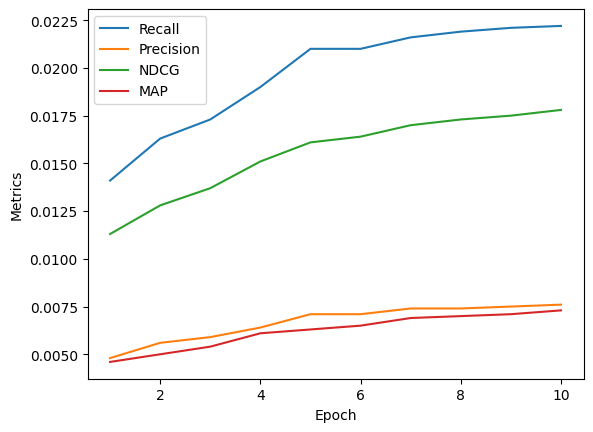

In [29]:
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

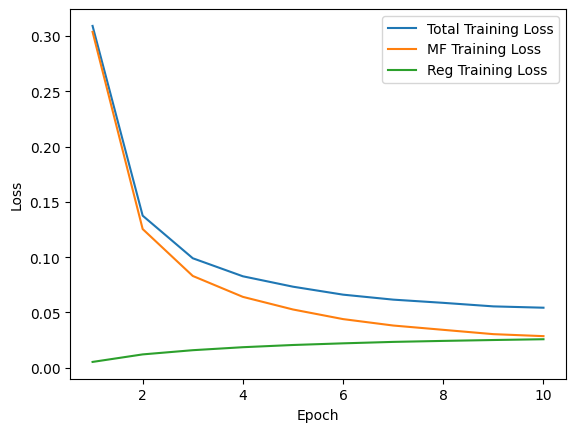

In [30]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [31]:
lightGCN = LightGCN(train, n_users, n_songs, 3, 128)
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([118124, 128])


In [32]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = []

for epoch in tqdm(range(EPOCHS)):
    # Calculate the number of batches per epoch
    n_batch = int(len(train)/BATCH_SIZE)

    # Initialization
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
    best_ndcg = -1
    train_start_time = time.time()

    # Set the model in training mode
    lightGCN.train()

    # Iterate over each batch in the training dataset
    for batch_idx in range(n_batch):
        # Reset gradients
        optimizer.zero_grad()
        # Load data for the current batch
        users, pos_items, neg_items = data_loader(train, user_col, song_col, BATCH_SIZE, n_users, n_songs)
        # Perform forward pass through the model
        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)
        # Compute BPR loss and regularization loss
        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0, LAMBDA)
        reg_loss = DECAY * reg_loss  # Apply weight decay
        # Combine losses to get the final loss
        final_loss = mf_loss + reg_loss
        # Perform backward pass and update model parameters
        final_loss.backward()
        optimizer.step()
        # Record losses for monitoring
        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    # model evaluation
    lightGCN.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_songs, train, test, K)


    eval_time = time.time() - train_end_time

    # calculate and append the mean values of various loss and evaluation metrics for each epoch to their respective lists.
    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)

  0%|          | 0/10 [00:00<?, ?it/s]

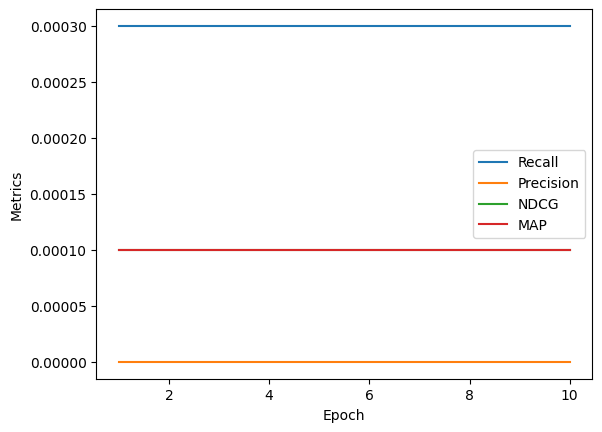

In [33]:
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

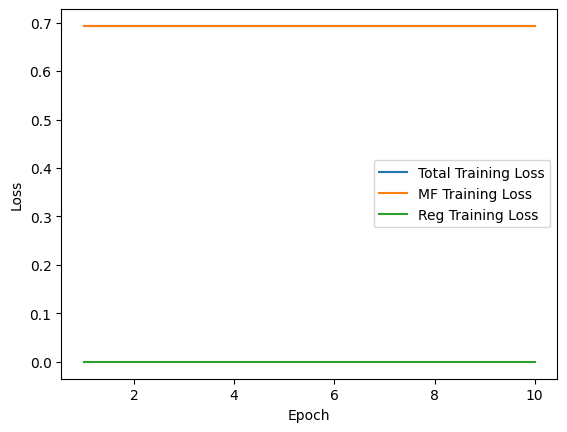

In [34]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [35]:
lightGCN = LightGCN(train, n_users, n_songs, 4, 64)
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([118124, 64])


In [36]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = LR)


In [37]:
EPOCHS = 20

In [38]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = []

for epoch in tqdm(range(EPOCHS)):
    # Calculate the number of batches per epoch
    n_batch = int(len(train)/BATCH_SIZE)

    # Initialization
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
    best_ndcg = -1
    train_start_time = time.time()

    # Set the model in training mode
    lightGCN.train()

    # Iterate over each batch in the training dataset
    for batch_idx in range(n_batch):
        # Reset gradients
        optimizer.zero_grad()
        # Load data for the current batch
        users, pos_items, neg_items = data_loader(train, user_col, song_col, BATCH_SIZE, n_users, n_songs)
        # Perform forward pass through the model
        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)
        # Compute BPR loss and regularization loss
        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0, LAMBDA)
        reg_loss = DECAY * reg_loss  # Apply weight decay
        # Combine losses to get the final loss
        final_loss = mf_loss + reg_loss
        # Perform backward pass and update model parameters
        final_loss.backward()
        optimizer.step()
        # Record losses for monitoring
        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    # model evaluation
    lightGCN.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_songs, train, test, K)


    eval_time = time.time() - train_end_time

    # calculate and append the mean values of various loss and evaluation metrics for each epoch to their respective lists.
    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)

  0%|          | 0/20 [00:00<?, ?it/s]

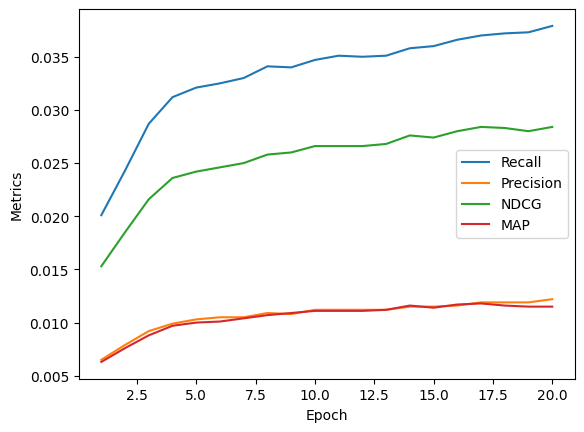

In [39]:
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

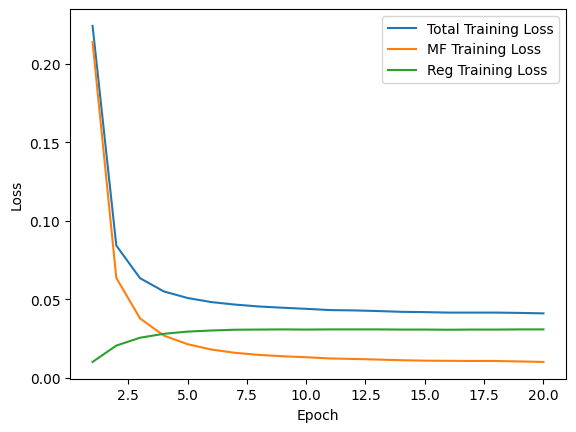

In [40]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()